<a href="https://colab.research.google.com/github/hirokimituya/stock-price-analysis/blob/main/technical_analysis/%E6%A0%AA%E4%BE%A1%E5%88%86%E6%9E%90%E9%96%A2%E6%95%B0_mplfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.9 MB/s eta 0:00:00


In [4]:
# Ta-Libをインストールしてimportしようとするとエラーとなるため、代わりにpandas_taを使用している
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [5]:
# Ta-Libの代替としてpandas_taを利用している。Ta-Libの関数名を小文字にしたものがあるイメージ
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=cc10349d50ef088f2e662e57d66d189c5b70d2f291f8f3bc98e6bbeb87309857
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [6]:
!pip install yahoo_finance_api2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas_datareader.data as pdr

# 株価データを取得するメソッド
def get_stock_data(code):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :return: 株価データのデータフレーム
    """
    df = pdr.DataReader(f'{code}.JP', 'stooq').sort_index()
    return df

In [8]:
from yahoo_finance_api2 import share as yapi2
from yahoo_finance_api2.exceptions import YahooFinanceError
import datetime as dt
from datetime import date,timedelta
import pandas as pd

# 株価データを取得するメソッド
def get_stock_data_yapi2(code, period_type='year', period=10):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :param period_type: 取得する株価データの期間の単位（例: 'year', 'month', 'week', 'day'）
    :param period: 取得する株価データの期間の数値
    :return: 株価データのデータフレーム（もし株価データが存在しない場合は、None）
    """
    if period_type == 'month':
        period_type_value = yapi2.PERIOD_TYPE_MONTH
    elif period_type == 'week':
        period_type_value = yapi2.PERIOD_TYPE_WEEK
    elif period_type == 'day':
        period_type_value = yapi2.PERIOD_TYPE_DAY
    else:
        period_type_value = yapi2.PERIOD_TYPE_YEAR

    try:
        data = yapi2.Share(f'{code}.T').get_historical(
            period_type_value,
            period,
            yapi2.FREQUENCY_TYPE_DAY,
            1
        )
    except YahooFinanceError as e:
        print(e.message)
        print(f'銘柄コード[{code}]の株価情報を取得できなかったため、スキップしました。')
        return None

    df = pd.DataFrame(data)

    try:
        # タイムスタンプをDateTime型に変更
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    except KeyError as e:
        print(e)
        print(f'銘柄コード[{code}]の株価情報を取得できなかったため、スキップしました。')
        return None

    # 日本時間へ変換
    df['Date'] = df['datetime'] + dt.timedelta(hours=9)

    # インデックスをDateカラムに設定
    df.index = pd.to_datetime(df['Date'].dt.date)

    # 不要なカラムを削除
    del df['Date'], df['datetime'], df['timestamp']

    # 各カラムの最初の文字を大文字に変換
    for col in df.columns:
        df[f'{col.capitalize()}'] = df[col]
        del df[col]

    return df

<Axes: xlabel='Date'>

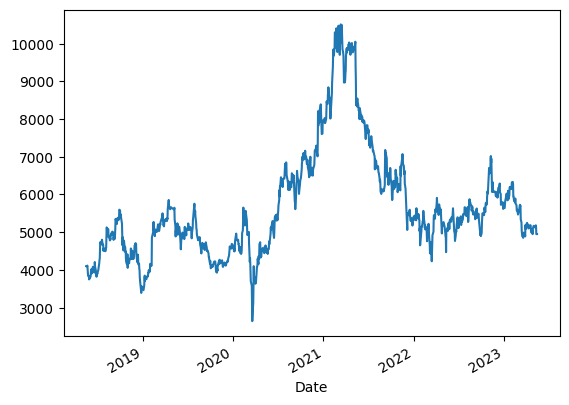

In [9]:
# ソフトバンクの株価データ取得
df = get_stock_data(9984)
df['Close'].plot()

### 高値と安値で差が大きいデータが多いほど、短期間での売買で利益を出しやすい銘柄であると判断できる

In [10]:
# 高値と安値の差が300円以上の株価データ
df.query('High - Low >= 300').tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-08,6655.0,6997.0,6650.0,6929.0,33680300.0
2022-11-14,6353.0,6453.0,5956.0,6068.0,40860800.0
2022-11-16,6090.0,6400.0,6090.0,6328.0,32497500.0
2022-11-18,6355.0,6363.0,6044.0,6075.0,25586100.0
2022-12-20,6038.0,6041.0,5715.0,5726.0,16122200.0


### テクニカル指標をチャートに描画する

In [11]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=e731f2543e5fa5fc57d25fcf9b1543790e1ba7931fb6545cb6ad1d57becb648f
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [12]:
# Google Colaboratoryに画像を保存できるように設定
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/')

In [21]:
import pandas_ta as ta
import mplfinance as mpf
import matplotlib
import datetime as dt
import japanize_matplotlib

# ローソク足と出来高を表示するメソッド
# TODO: 高値と安値の差を棒グラフ（ヒストグラム）で表示できるようにしたらよいかも
# TODO: x軸の目盛りの日付を開始日と終了日が必ず表示されるようにして、表示される日付の数も増やすようにする
# TODO: ゴールデンクロスとデッドクロスが表示できるようにする
def show_plot(code, start, end=dt.date.today(), sma=[], bbands={}, macd=[], rsi=[], stoch=[], deviation_rate=False, volume=False, width=2, height=1, figscale=1.0, period=None, title=''):
    """ローソク足や移動平均線のチャートを表示する

    :param code: 取得する株価データの銘柄コード
    :param start: 取得する株価データの開始日
    :param end: 取得する株価データの終了日
    :param sma: チャートに移動平均線を表示するためのリスト（例: [5, 25, 75]）
    :param bbands: チャートにボリンジャーバンドを表示するための辞書（例: {'sma': 25, 'bbands': [1, 2]} or {'sma': 25, 'fill': True}）
    :param macd: チャートにMACDを表示するための短期／長期／シグナルの移動平均線の日数のリスト（例: [12, 26, 9]）
    :param rsi: チャートにRSIを表示するための移動平均線の日数のリスト（例: [14, 28]）
    :param stoch: チャートにスローストキャスティクスを表示するための移動平均線の日数のリスト（例: [14, 3, 3]）
    :param deviation_rate: 移動平均線の乖離率を表示するかどうかのブール値
    :param volume: チャートに出来高を表示するかどうかのブール値
    :param width: チャートの幅（縦横比）
    :param height: チャートの高さ（縦横比）
    :param figscale: チャートの拡大縮小表示
    :param period: 表示するチャートの期間をどの単位でまとめるか（'W' or 'M'）
    :param title: チャートのタイトルを表示
    """
    # 株価データの取得
    df = get_stock_data_yapi2(code)

    # 月足、周足にリサンプリング
    if period in ('M', 'W'):
        resampled = df.resample(period)
        df = resampled.aggregate({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    
    close = df['Close']
    
    # ▼▼▼▼▼テクニカル指標の算出▼▼▼▼▼

    # ①移動平均線
    for ma in sma:
        df[f'ma{ma}'] = ta.sma(close, ma)

    # ②ボリンジャーバンド
    if bbands:
        if not sma:
            df[f'ma{bbands["sma"]}'] = ta.sma(close, bbands['sma'])
        # 辞書bbandsのキーに'fill'が存在し、値がTrueかどうか確認
        if 'fill' not in bbands or not bbands['fill']:
            for n in bbands['bbands']:
                bbands_df = ta.bbands(close, length=bbands["sma"], std=n)
                df[f'lower{n}'], df[f'upper{n}'] = bbands_df.iloc[:, 0], bbands_df.iloc[:, 2]
        else:
            bbands_df = ta.bbands(close, length=bbands["sma"], std=2)
            df['lower2'], df['upper2'] = bbands_df.iloc[:, 0], bbands_df.iloc[:, 2]

    # ③乖離率
    if deviation_rate:
        for ma in sma:
            df[f'ma{ma}_deviation_rate'] = (close - df[f'ma{ma}']) / df[f'ma{ma}'] * 100
    
    # ④MACD
    if macd:
        macd_df = ta.macd(close, fast=macd[0], slow=macd[1], signal=macd[2])
        df['macd'], df['hist'], df['macd_signal'] = macd_df.iloc[:, 0], macd_df.iloc[:, 1], macd_df.iloc[:, 2]
    
    # ⑤RSI
    if rsi:
        for ma in rsi:
            df[f'rsi{ma}'] = ta.rsi(close, ma)
    
    # ⑥ストキャスティクス
    if stoch:
        stoch_df = ta.stoch(df['High'], df['Low'], close, k=stoch[0], d=stoch[1], smooth_k=stoch[2])
        df['slowK'], df['slowD'] = stoch_df.iloc[:, 0], stoch_df.iloc[:, 1]

    # ▲▲▲▲▲テクニカル指標の算出▲▲▲▲▲

    # 日付で絞り込み
    cdf = df[start:end]

    # チャートに表示するために使用する変数
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'grey']
    icolor = 0  # panel=0のcolorのインデックスを表す
    panel = 0 if not volume else 1
    apd = []
    labels_dict = {0: []}
    yticks_dict = {}

    # ▼▼▼▼▼テクニカル指標のチャートへの表示▼▼▼▼▼

    # ①移動平均線
    for ma in sma:
        apd.append(mpf.make_addplot(cdf[f'ma{ma}'], color=colors[icolor], panel=0, width=0.7))
        icolor += 1
        labels_dict[0].append(f'MA({ma})')
    
    # ②ボリンジャーバンド
    bbands_fill_between = {}
    if bbands:
        if not sma:
            apd.append(mpf.make_addplot(cdf[f'ma{bbands["sma"]}'], color=colors[icolor], panel=0, width=0.5))
            icolor += 1
            labels_dict[0].append(f'MA({bbands["sma"]})')
        # 辞書bbandsのキーに'fill'が存在し、値がTrueかどうか確認
        if 'fill' not in bbands or not bbands['fill']:
            for n in bbands['bbands']:
                apd.append(mpf.make_addplot(cdf[f'upper{n}'], color=colors[icolor], panel=0, width=0.5))
                apd.append(mpf.make_addplot(cdf[f'lower{n}'], color=colors[icolor], panel=0, width=0.5))
                icolor += 1
                labels_dict[0].extend([f'+{n}σ', f'−{n}σ'])
        else:
            bbands_fill_between = {'y1': cdf['lower2'].values, 'y2': cdf['upper2'].values, 'color': colors[icolor], 'alpha': 0.2}
            icolor += 1
            labels_dict[0].append('±2σ')
    
    # ③乖離率
    if deviation_rate:
        for ma, color in zip(sma, colors):
            panel += 1
            apd.append(mpf.make_addplot(cdf[f'ma{ma}_deviation_rate'], color=color, panel=panel, width=0.7))
            labels_dict.setdefault(panel, [])
            labels_dict[panel].append(f'MA({ma})_乖離率')
    
    # ④MACD
    if macd:
        panel += 1
        apd.append(mpf.make_addplot(cdf['macd'], color=colors[0], panel=panel, width=0.7))
        apd.append(mpf.make_addplot(cdf['macd_signal'], color=colors[1], panel=panel, width=0.7))
        apd.append(mpf.make_addplot(cdf['hist'], color='grey', panel=panel, type='bar'))
        labels_dict.setdefault(panel, [])
        labels_dict[panel].extend([f'MACD({macd[0]}, {macd[1]})', f'シグナル({macd[2]})', 'ヒストグラム'])
    
    # ⑤RSI
    if rsi:
        panel += 1
        rsi_color = 0
        for ma in rsi:
            apd.append(mpf.make_addplot(cdf[f'rsi{ma}'], color=colors[rsi_color], panel=panel, width=0.7))
            rsi_color += 1
            labels_dict.setdefault(panel, [])
            labels_dict[panel].append(f'RSI({ma})')
        yticks_dict.setdefault(panel, [])
        yticks_dict[panel].extend([30, 70])
    
    # ⑥ストキャスティクス
    if stoch:
        panel += 1
        apd.append(mpf.make_addplot(cdf['slowK'], color=colors[0], panel=panel, width=0.7))
        apd.append(mpf.make_addplot(cdf['slowD'], color=colors[1], panel=panel, width=0.7))
        labels_dict.setdefault(panel, [])
        labels_dict[panel].extend([f'Slow%K({stoch[0]}, {stoch[1]})', f'Slow%D({stoch[2]})'])
        yticks_dict.setdefault(panel, [])
        yticks_dict[panel].extend([20, 80])

    # ▲▲▲▲▲テクニカル指標のチャートへの表示▲▲▲▲▲
    
    # ローソク足の色と日本語対応するためのチャートのスタイル作成
    mc = mpf.make_marketcolors(up='#F48FB1', down='#90bff9', volume='#999', edge='inherit', wick='inherit')
    cs  = mpf.make_mpf_style(
        marketcolors=mc,
        gridcolor="lightgray",
        rc={"font.family":'IPAexGothic'},
    )

    # 描画情報を取得
    if not bbands_fill_between:
        fig, axes = mpf.plot(cdf, type='candle', figratio=(width, height), figscale=figscale, volume=volume, style=cs, addplot=apd, returnfig=True, datetime_format="%Y/%m/%d", title=title)
    else:
        fig, axes = mpf.plot(cdf, type='candle', figratio=(width, height), figscale=figscale, volume=volume, style=cs, addplot=apd, returnfig=True, datetime_format="%Y/%m/%d", title=title, fill_between=bbands_fill_between)

    # 数値に「,」をつける
    axes[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # ラベルを追加
    if labels_dict[0]:
        axes[0].legend([None] * (len(labels_dict[0]) + 2))
        handles = axes[0].get_legend().legend_handles
        axes[0].legend(handles=handles[2:], labels=labels_dict[0], loc='upper left')
    for panel, labels in labels_dict.items():
        if panel != 0:
            axes[panel * 2].legend(labels, loc='upper left')
    
    # y軸の目盛りの値を変更
    for panel, yticks in yticks_dict.items():
        axes[panel * 2].set_yticks(yticks)
        axes[panel * 2].grid(axis='y', color=colors[2], alpha=0.4)
    
    fig.subplots_adjust(top=0.85, hspace=0.5)

    # チャートを表示
    fig.show()

    # チャートを画像として保存
    # fig.savefig(f'{title}.png', dpi=200)

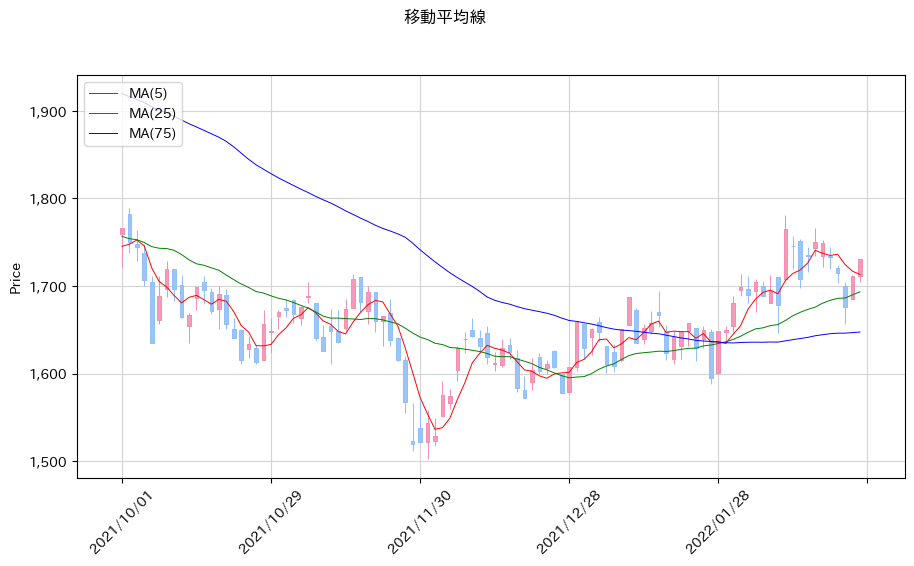

In [22]:
# 移動平均線をチャートに表示する
show_plot(7616, '2021-10-1', '2022-2-28', sma=[5, 25, 75], title='移動平均線')

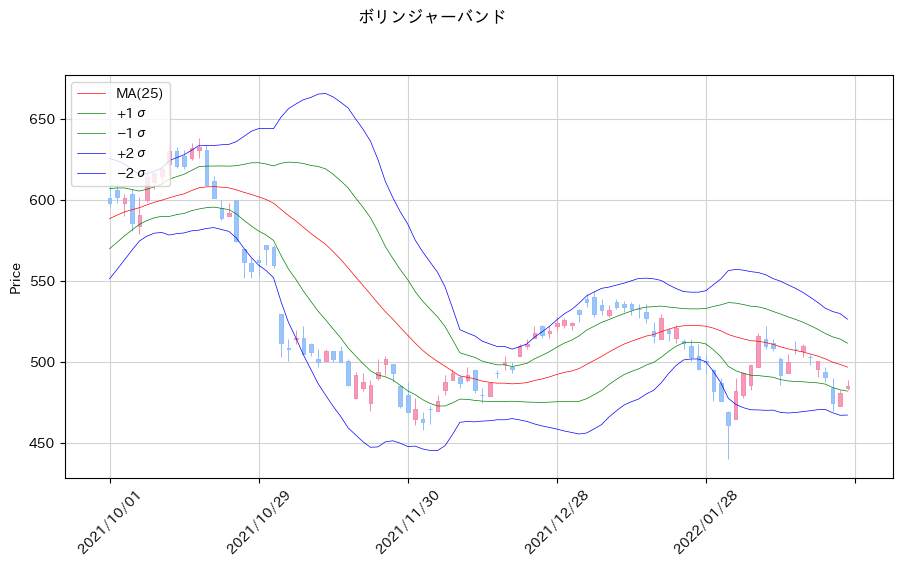

In [23]:
# ボリンジャーバンドをチャートに表示する
show_plot(4902, '2021-10-1', '2022-2-28', bbands={'sma': 25, 'bbands': [1, 2]}, title='ボリンジャーバンド')

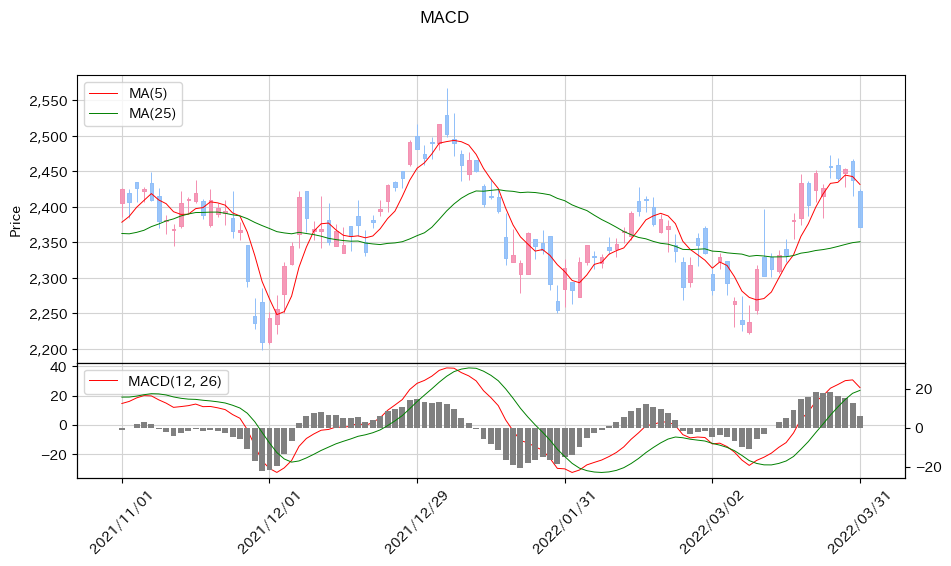

In [24]:
show_plot(1928, '2021-11-1', '2022-3-31', sma=[5, 25], macd=[12, 26, 9], title='MACD')

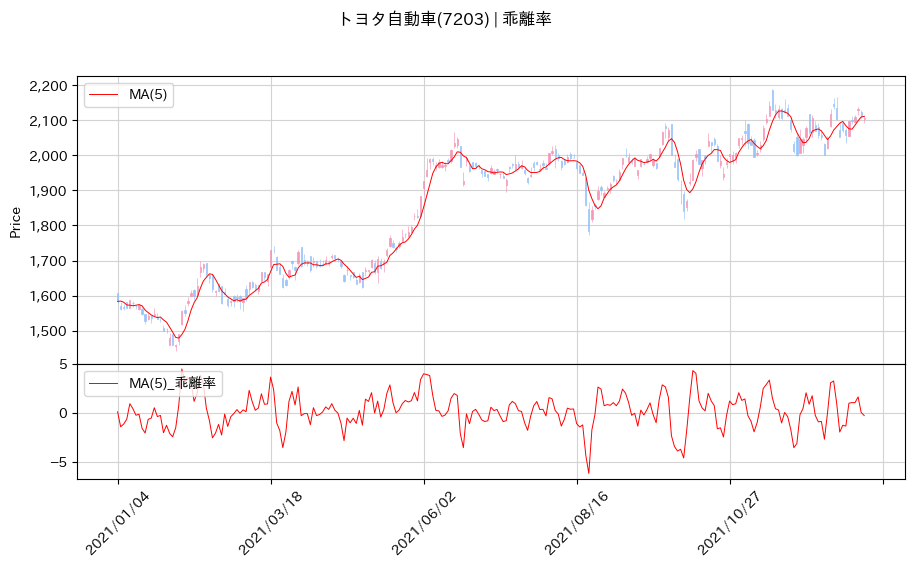

In [25]:
show_plot(7203, '2021-1-1', '2021-12-31', sma=[5], deviation_rate=True, title='トヨタ自動車(7203) | 乖離率')

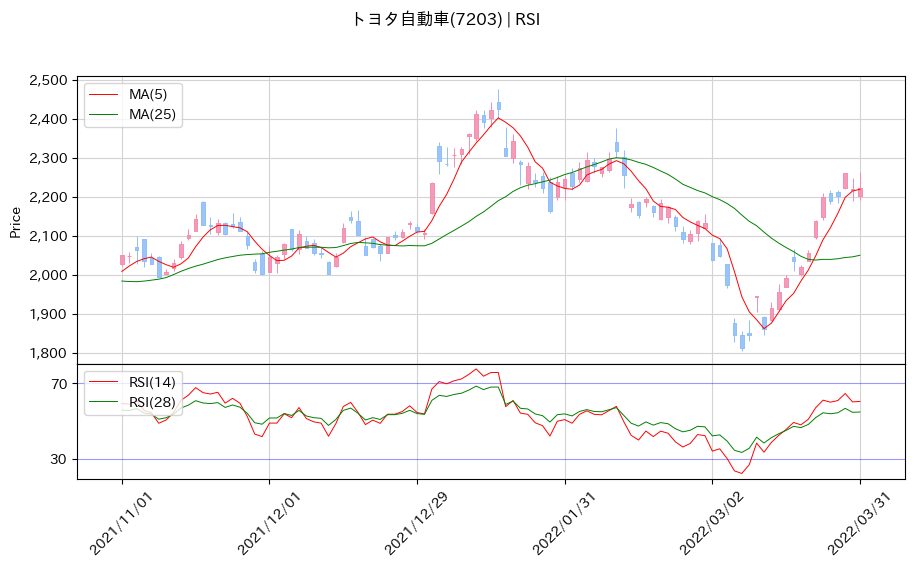

In [26]:
show_plot(7203, '2021-11-1', '2022-3-31', sma=[5, 25], rsi=[14, 28], title='トヨタ自動車(7203) | RSI')

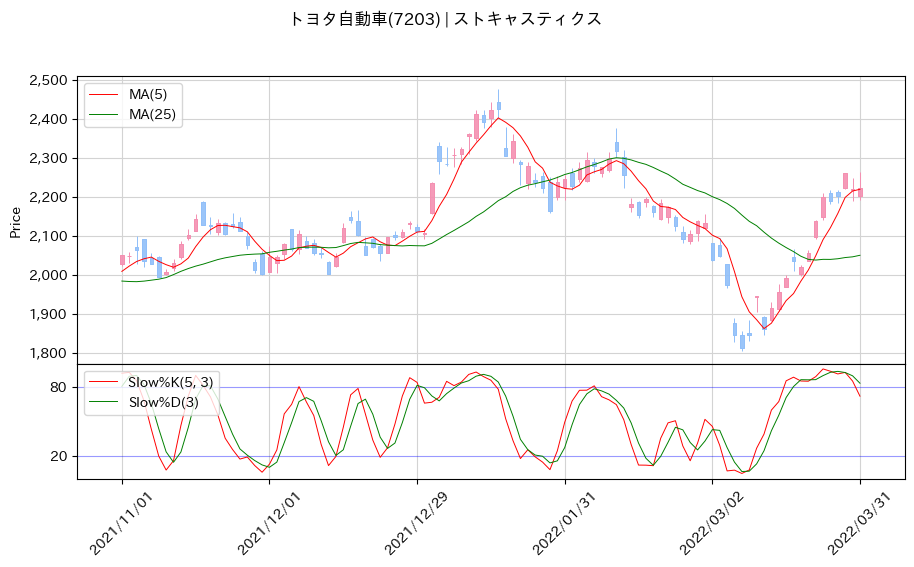

In [27]:
show_plot(7203, '2021-11-1', '2022-3-31', sma=[5, 25], stoch=[5, 3, 3], title='トヨタ自動車(7203) | ストキャスティクス')

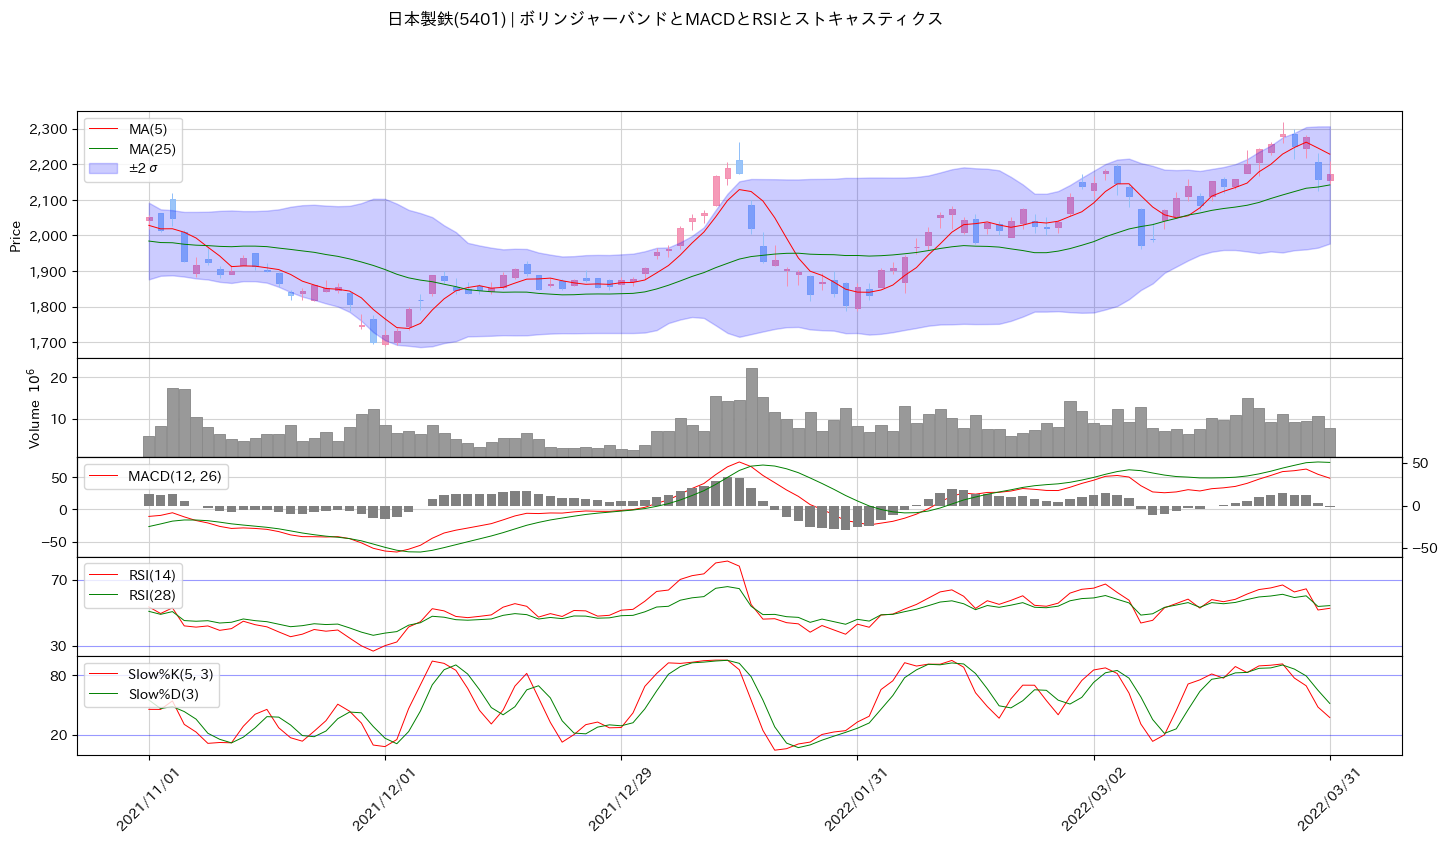

In [28]:
show_plot(5401, '2021-11-1', '2022-3-31', sma=[5, 25], bbands={'sma': 25, 'fill': True}, macd=[12, 26, 9], rsi=[14, 28], stoch=[5, 3, 3], title='日本製鉄(5401) | ボリンジャーバンドとMACDとRSIとストキャスティクス', volume=True, figscale=1.6)